In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.express as px
import shap
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson

# Data Loading and Cleaning

In [3]:
# Load data
df = pd.read_excel('Raw_Data.xlsx')

# Data cleaning
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)


# Feature Engineering


In [4]:
# Feature Engineering: Creating new features
df['Log_Revenue'] = np.log(df['Revenue'] + 1)  # Log transformation to handle skewness
df['Revenue_per_Year'] = df['Revenue'] / df['Year']  # Creating new feature based on revenue per year


# Data Scaling


In [5]:
# Scaling the features
scaler = StandardScaler()
df[['Revenue', 'Year', 'State ID']] = scaler.fit_transform(df[['Revenue', 'Year', 'State ID']])


# Advanced Statistics

In [6]:
# Advanced Statistics for Revenue
def calc_advanced_stats(column):
    print(f"Stats for {column.name}")
    mean = np.mean(column)
    median = np.median(column)
    std_dev = np.std(column)
    skewness = stats.skew(column)
    kurtosis = stats.kurtosis(column)
    print(f"Mean: {mean}, Median: {median}, Std Dev: {std_dev}")
    print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")
    return mean, median, std_dev, skewness, kurtosis

calc_advanced_stats(df['Revenue'])


Stats for Revenue
Mean: -1.9737298215558337e-16, Median: 0.016182805294382027, Std Dev: 0.9999999999999997
Skewness: 0.0069805524857214606, Kurtosis: -1.2186922265311737


(-1.9737298215558337e-16,
 0.016182805294382027,
 0.9999999999999997,
 0.0069805524857214606,
 -1.2186922265311737)

The output shows that the "Revenue" data is fairly balanced, with an average value close to zero and a spread of values close to 1. The data is also distributed fairly evenly, without a strong skew to either side.

# Visualization

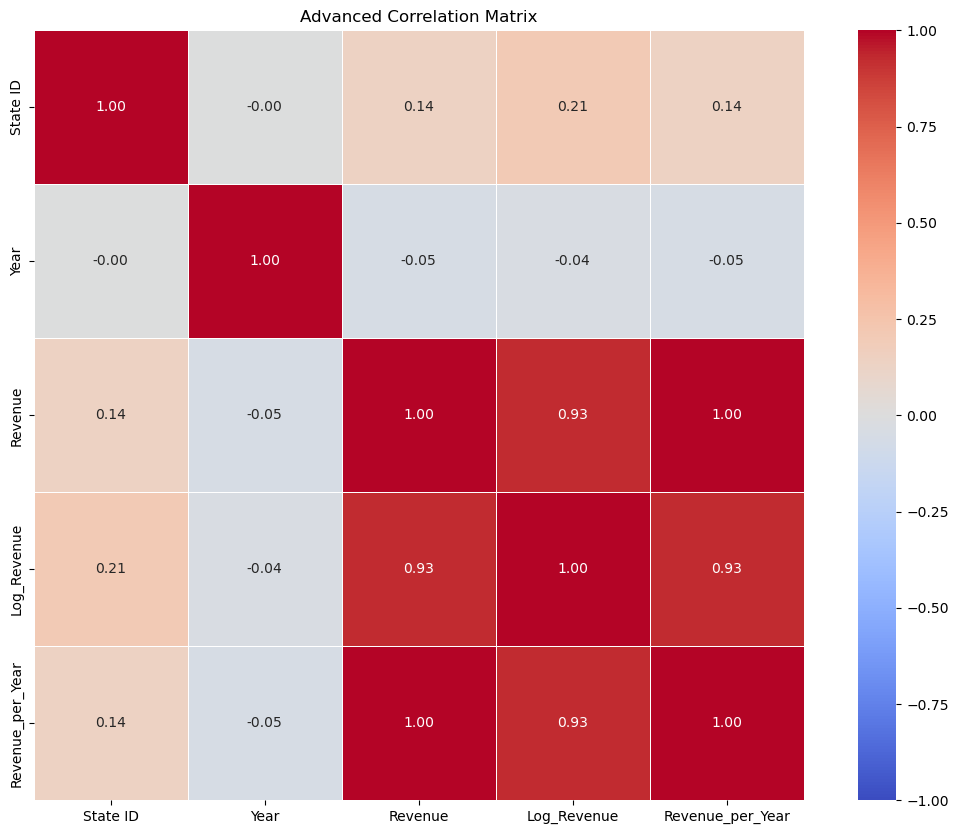

In [7]:
# Correlation Matrix Heatmap
plt.figure(figsize=(14, 10))
corr = df[['State ID', 'Year', 'Revenue', 'Log_Revenue', 'Revenue_per_Year']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5, square=True)
plt.title('Advanced Correlation Matrix')
plt.show()


The heatmap shows how closely related the different variables are to each other. 

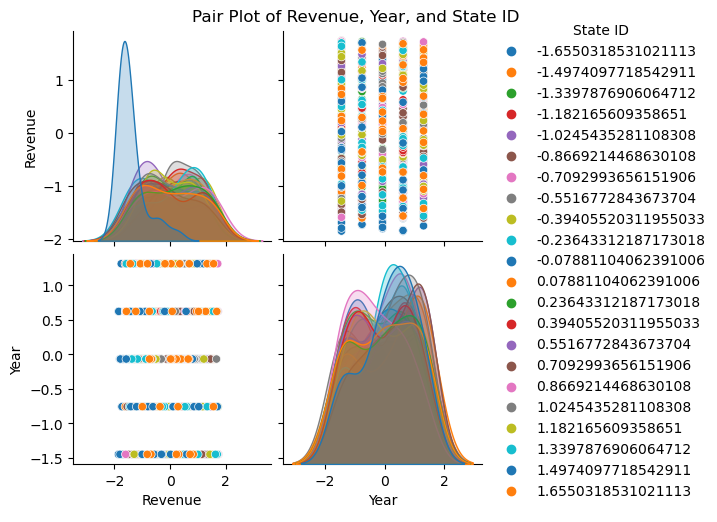

In [8]:
# Pair Plot
sns.pairplot(df[['Revenue', 'Year', 'State ID']], diag_kind='kde', hue='State ID', palette='tab10')
plt.suptitle('Pair Plot of Revenue, Year, and State ID', y=1.02)
plt.show()


The pair plot shows how the variables Revenue, Year, and State ID are related to each other.

In [9]:
# Interactive 3D Scatter Plot
fig = px.scatter_3d(df, x='Year', y='Revenue', z='State ID', color='State Name',
                    title='3D Scatter Plot of Revenue, Year, and State ID',
                    color_continuous_scale='Viridis')
fig.show()


The 3D scatter plot shows how the variables Year, Revenue, and State ID are related to each other. It helps to visualize 
the data and identify any patterns or relationships between the variables.

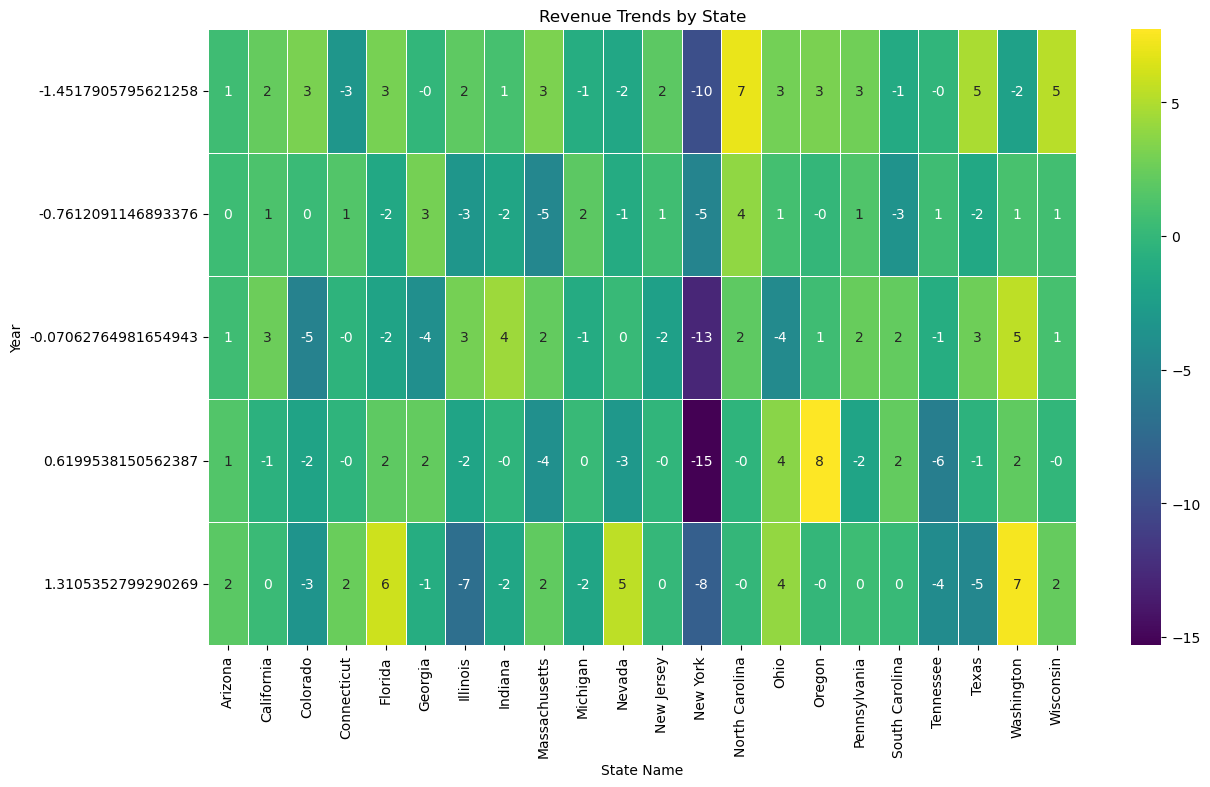

In [10]:
# Heatmap of Revenue Trends by State
pivot_table = df.pivot_table(index='Year', columns='State Name', values='Revenue', aggfunc='sum')
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.0f', linewidths=0.5)
plt.title('Revenue Trends by State')
plt.xlabel('State Name')
plt.ylabel('Year')
plt.show()


The heatmap shows how the revenue of different states has changed over time. The colors indicate the amount of 
revenue each state earned in each year.

# Machine Learning and Model Evaluation 


In [11]:
#Polynomial Features and PCA
# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df[['Year', 'State ID']])

# PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[['Revenue', 'Year', 'State ID']])


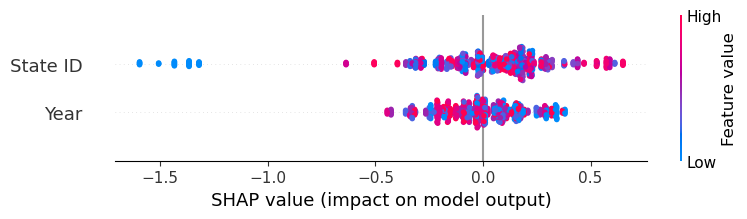

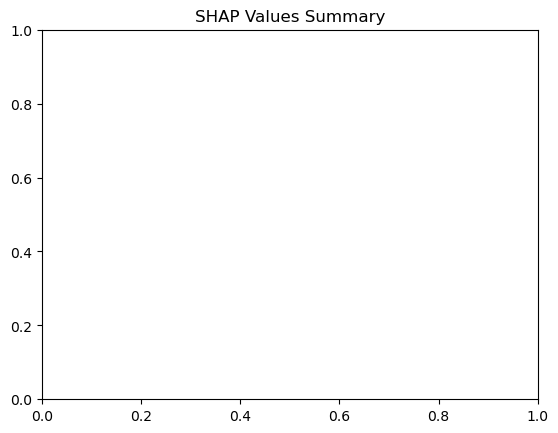

In [12]:
# Feature Importance with SHAP Values
X = df[['Year', 'State ID']]
y = df['Revenue']
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, feature_names=X.columns)
plt.title('SHAP Values Summary')
plt.show()


The plot shows how the variables State ID and Year affect the model's predictions. The x-axis shows the SHAP values,
which indicate the impact of each feature on the model's output. The y-axis shows the feature values. 
The color of the points represents the magnitude and direction of the impact.

# Regression Analysis

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     8.550
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           0.000212
Time:                        20:27:25   Log-Likelihood:                -1115.3
No. Observations:                 792   AIC:                             2237.
Df Residuals:                     789   BIC:                             2251.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -8.899e-16      0.035  -2.53e-14

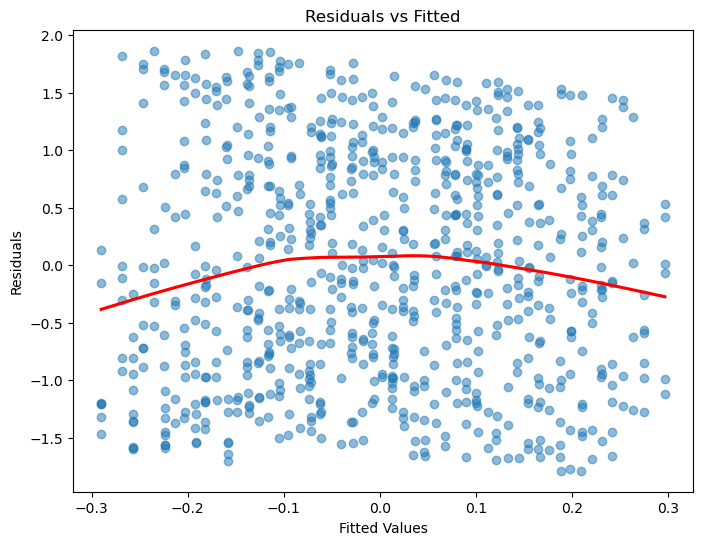

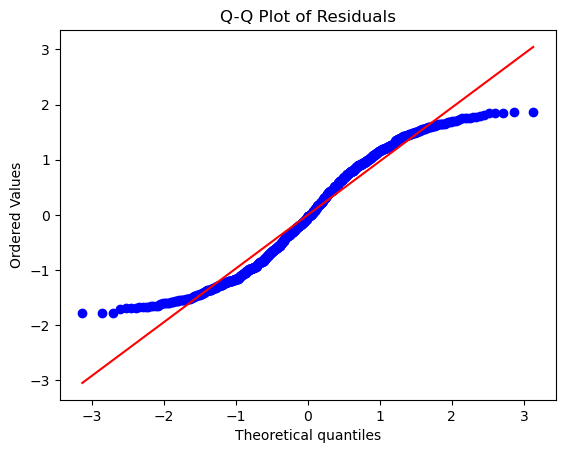

In [13]:
# Regression Analysis with OLS
model = ols('Revenue ~ Year + Q("State ID")', data=df).fit()
print(model.summary())

# Breusch-Pagan Test for Heteroscedasticity
_, pval, __, f_pval = het_breuschpagan(model.resid, model.model.exog)
print(f'Breusch-Pagan p-value: {pval}, F-statistic p-value: {f_pval}')

# Residuals vs Fitted Plot
residuals = model.resid
fitted = model.fittedvalues
plt.figure(figsize=(8, 6))
sns.regplot(x=fitted, y=residuals, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color':'red'})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q Plot for Residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


The plot shows the residuals (the difference between the actual values and the predicted values) of the regression model.
The top plot shows a scatter plot of the residuals against the fitted values. The bottom plot shows a Q-Q plot of
the residuals.Both plots suggest that the residuals are not normally distributed.

# Time Series Analysis

In [14]:
# ARIMA Model for Revenue
model_arima = ARIMA(df['Revenue'], order=(1, 1, 1))
model_fit = model_arima.fit()
print(model_fit.summary())

# Forecasting with ARIMA
forecast = model_fit.forecast(steps=5)
print(forecast)


                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  792
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1104.175
Date:                Fri, 11 Oct 2024   AIC                           2214.351
Time:                        20:27:25   BIC                           2228.371
Sample:                             0   HQIC                          2219.739
                                - 792                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0345      0.038      0.919      0.358      -0.039       0.108
ma.L1         -0.9493      0.011    -86.096      0.000      -0.971      -0.928
sigma2         0.9523      0.067     14.127      0.0

The output shows the results of an ARIMA model for forecasting revenue. The model is ARIMA(1,1,1), 
which means that it includes an autoregressive term of order 1, an integrated term of order 1, and
a moving average term of order 1. The model has a good fit, as indicated by the low AIC and BIC values. 
The forecasted values for the next 5 periods are also provided.

# Clustering

C:\Users\18473\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



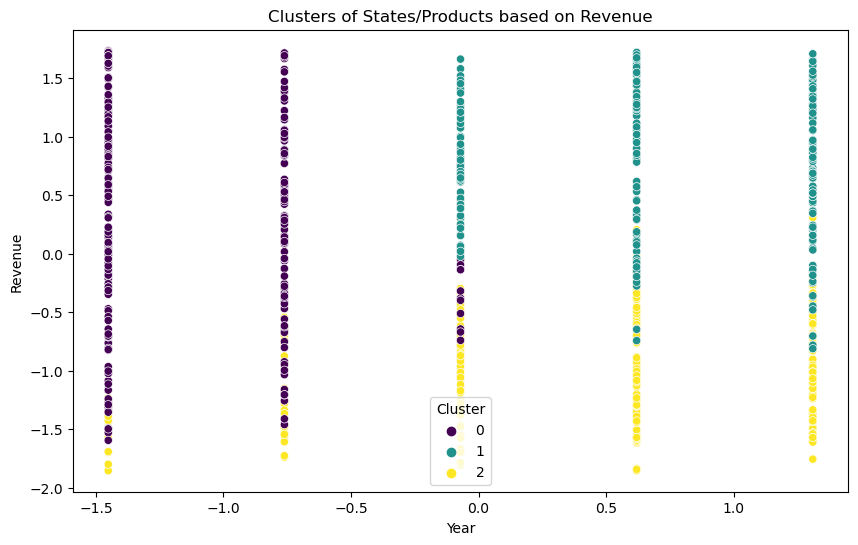

In [15]:
# KMeans Clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Revenue', 'Year', 'State ID']])
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Clustering Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Revenue', hue='Cluster', data=df, palette='viridis')
plt.title('Clusters of States/Products based on Revenue')
plt.show()


The plot shows the results of clustering the data into 3 clusters based on the variables Revenue, Year, and State ID. 
The colors represent the different clusters. The plot suggests that there are three distinct groups of states/products
based on their revenue and year.

# Final Model Evaluation


RMSE: 1.0488901320063793


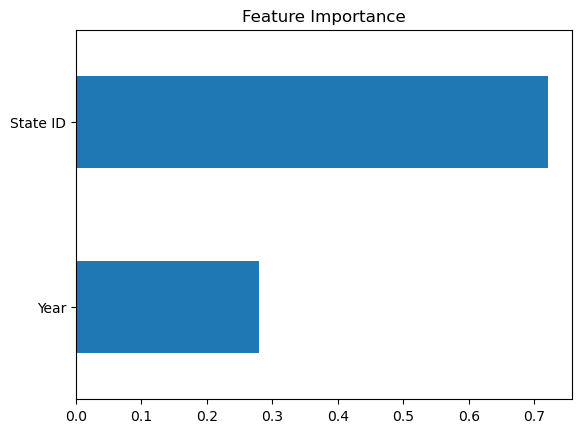

In [16]:
# Random Forest Regressor for Revenue Prediction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("\nRMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Feature Importance from Random Forest
importances = rf_model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
feature_importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()


The output shows the results of a random forest regression model for predicting revenue. 
The RMSE of 1.0488901320063793 indicates the average error between the predicted and actual revenue values. 
The feature importance plot shows that State ID is the most important feature in predicting revenue,
while Year is less important.

# Interactive Visualizations

In [17]:
# Interactive Choropleth Map
fig = px.choropleth(
    df,
    locations="State Name",
    locationmode='USA-states',
    color="Revenue",
    hover_name="State Name",
    scope="usa",
    title="Revenue by State (Billions)",
    color_continuous_scale="Viridis",
    range_color=(df['Revenue'].min() / 1000000000, df['Revenue'].max() / 1000000000)
)
fig.update_traces(colorbar_title="Revenue (Billions)")
fig.show()


The output is an interactive choropleth map that shows the revenue of each state in the United States. The color of each 
state represents its revenue level, with darker colors indicating higher revenue and lighter colors indicating lower revenue.


# Durbin-Watson Test

In [18]:
# Linear Regression Model for Durbin-Watson Test
X_with_const = sm.add_constant(X)
model_interaction = sm.OLS(y, X_with_const).fit()
dw_stat = durbin_watson(model_interaction.resid)
print(f'Durbin-Watson statistic: {dw_stat}')


Durbin-Watson statistic: 1.7819651370862921


The output shows the result of a Durbin-Watson test, which is used to test for autocorrelation in the residuals of 
a regression model. The Durbin-Watson statistic is 1.7819651370862921. This value suggests that there is no significant 
autocorrelation in the residuals.